### Libs

In [1]:
from tqdm import tqdm
import numpy as np
import os
import random
import glob
import re

import cv2
import geopandas as gpd
import pandas as pd

import albumentations as A

import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import model
import metrics
import config
import utis
import train_val_test

from matplotlib import pyplot as plt, cm
import plotly.express as px

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

### Weights and Biases

In [28]:
!wandb login 

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Custom Split Dataset

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'

FILTER_PATH = '../data/geopackages/patch_keys.gpkg'
TEST_DATASET_PATH = '../data/test_dataset'

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')

In [3]:
# import rasterio as rio

# def train_images_paths(paths:list, test:list) -> list:
#     ''' Returns list of images paths that DOES NOT exist on the test list'''
#     train_paths = []
#     for i in paths:
#         if not np.isin(i, test):
#             train_paths.append(i)
#     return train_paths

# def get_file_index(file:str) -> str:
#     '''Returns the idx name from file name'''
#     return re.split(r"[/_.]\s*", file)[-2]

# def filtered_paths(current_paths:list, 
#                    filter_paths:list)-> list:
#     ''' Filters paths according to ID, keep only matching IDs '''
#     filtered_paths = []
#     for i in current_paths:
#         if np.isin(int(get_file_index(i)), list(filter_paths)):
#             filtered_paths.append(i)      
#     return filtered_paths

# def get_n_training_samples(image_paths,
#                            mask_paths,
#                            filtered_idxs, 
#                            number_training_patchs):
    
#         all_coarse_idxs = [get_file_index(i) for i in filtered_idxs]

#         # select random percentage of coarse labels
#         random.seed(41)
#         val_samples = int(0.30*number_training_patchs)
#         n_samples = number_training_patchs + int(0.30*number_training_patchs)
#         sampled_coarse_idxs = random.sample(all_coarse_idxs, n_samples)
        
#         # get the paths 
#         X_idxs = filtered_paths(image_paths, sampled_coarse_idxs) 
#         y_idxs = filtered_paths(mask_paths, sampled_coarse_idxs)
        
#         return val_samples, X_idxs, y_idxs
    
# def get_coords (image_list:list) -> dict:
#     '''
#     Return the rasterio profile of the images
#     Args:
#     image_list (list) : list of image paths
#     Returns:
#     coords (dict) : rasterio profile with image id
#     '''
#     coords = {}
#     for img in image_list:
#         # and its respective id
#         ids = get_file_index(img)

#         # get the profile of the patches
#         with rio.open(img) as src:
#             ras_data = src.read().astype('uint8')
#             profile = src.profile # get the original image profile

#         # save in a dict
#         coords.update([(ids, profile)])
#     return coords  

# def save_test_dataset(DEST_PATH:str,
#                       list_of_imgs:list) -> None:
    
#     ''' Save the test dataset in a separate folder
#     Args:
#     DEST_PATH (str): destination folder
#     list_of_imgs(list): list of images to save'''
    
#     coords = get_coords(list_of_imgs)
    
#     if not glob.glob(DEST_PATH +'/*.tif'):
#         #save test dataset on the dest folder WITH CRS
#         for img in list_of_imgs:
#             idx = utis.get_file_index(img)
#             print(img)
#             with rio.open(img) as src:
#                 data = src.read().astype('uint8')
#                 profile = src.profile

#             print(f'Saving dataset {DEST_PATH}/1942_{idx}.tif')
#             with rio.open(f'{DEST_PATH}/1942_{idx}.tif', 'w', **profile) as dst:
#                 dst.write(np.squeeze(data), 1)  

# def custom_split(filters:dict, image_paths:list, 
#                  mask_paths:list, 
#                  test_size:int, 
#                  data_portion:str, 
#                  DEST_PATH:str, 
#                  number_training_patchs = 20) -> list:
    
#     ''' Split the dataset based on the filter status
#     Args:
#     filters (dict): dict with the filtered paths by status
#     test_size (float): percentage of the dataset that will be used to test
#     data_portion (str):  'coarse_plus_fine_labels', 'fine_labels' or 'coarse_labels' define which portion of the data to use'''

#     # sample to the same size of the smallest dataset
#     veg_filters = filters.copy()

#     # coarse to very coarse is not considered in the fine dataset filter 
#     if np.isin('coarse_to_very_coarse', list(veg_filters.keys())):
#         del veg_filters['coarse_to_very_coarse']

#     # find the minimum dataset size among the classs in the filter, so all of them are equally represented    
#     sample_size = min([len(value) for key, value in veg_filters.items()])

#     # get all veg_filter idx
#     all_filter_idx = np.concatenate([i for i in veg_filters.values()])
    
#     # random sample sample_size points from each filter class to create the TEST DATASET
#     test_size = test_size/(sample_size*5) # 5 is the number of filters
#     test_size = int(sample_size*test_size)
#     test_dic = {key:value.sample(n=test_size, replace=False, random_state=0) for key, value in veg_filters.items()} # random sample
#     test_idx = np.concatenate([i for i in test_dic.values()])
    
#     # get the remaining patches from the filters to be the X_train and X_val of the fine patches
#     val_train_idxs = train_images_paths(all_filter_idx, test_idx)

#     # Filter the paths from the path lists
#     # Note the test dataset is the SAME for all data portions
#     X_test = filtered_paths(image_paths, test_idx) 
#     y_test = filtered_paths(mask_paths, test_idx) 
    
# #     # save a separate test dataset 
#     if data_portion == 'fine_labels':
#         save_test_dataset(f'{DEST_PATH}/images', X_test)
#         save_test_dataset(f'{DEST_PATH}/masks', y_test)
        
#     X_test = glob.glob(f'{DEST_PATH}/images' +'/*.tif') 
#     y_test = glob.glob(f'{DEST_PATH}/masks' +'/*.tif') 
    
#     portions = ['all_coarse_labels','coarse_plus_fine_labels', 'fine_labels', 'coarse_labels']
#     assert np.isin(data_portion, portions)
    
#     # Decide if using whole data or ONLY the filtered paths 
# #     if data_portion == 'coarse_plus_fine_labels': # all patches are used
# #         X_train = train_images_paths(f'{DEST_PATH}/images', X_test)
# #         y_train = train_images_paths(f'{DEST_PATH}/masks', y_test)

# #         X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42, shuffle=True)
        
#     if data_portion == 'coarse_labels': # if only coarse patches are used
#         coarse_X_idx = filtered_paths(image_paths, val_train_idxs) 
#         coarse_y_idx = filtered_paths(mask_paths, val_train_idxs) 
        
#         val_samples, coarse_X_idx, coarse_y_idx = get_n_training_samples(image_paths,
#                            mask_paths,
#                            coarse_X_idx, 
#                            number_training_patchs)

#         X_train, X_val, y_train, y_val = train_test_split(coarse_X_idx, coarse_y_idx, test_size=val_samples, random_state=42, shuffle=True)    
        
#     elif data_portion == 'fine_labels': # if only the fine patches are used 
#         fine_X_idx = filtered_paths(image_paths, val_train_idxs) 
#         fine_y_idx = filtered_paths(mask_paths, val_train_idxs) 
        
#         val_samples, fine_X_idx, fine_y_idx = get_n_training_samples(image_paths,
#                            mask_paths,
#                            fine_X_idx, 
#                            number_training_patchs)

#         X_train, X_val, y_train, y_val = train_test_split(fine_X_idx, fine_y_idx, test_size=val_samples, random_state=42, shuffle=True) 

#     return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
# Read file 
geo_df = gpd.read_file(FILTER_PATH) # contains the idxs with a selection of non-noisy and noisy data

# Define the filters 
filters = {'non_veg_idxs' : geo_df.query("status == 0")['index'],
       'veg_idxs' :  geo_df.query("status == 1")['index'], 
       'mixed': geo_df.query("status == 2")['index'], 
       'single_trees_idx' : geo_df.query("status == 3")['index'], 
       'hedgerows' : geo_df.query("status == 4")['index'], 
       'coarse_to_very_coarse': geo_df.query("status == 5")['index'][5:]}

# fix bug of the test_size
data_portion = 'coarse_labels' # ['coarse_plus_fine_labels', 'fine_labels', 'coarse_labels']
n_patches = 20

X_train, y_train, X_val, y_val, X_test, y_test = utis.custom_split(filters, test_size=40, 
                                                                   image_paths=image_paths, 
                                                                   mask_paths=mask_paths,  
                                                                   data_portion=data_portion,
                                                                   DEST_PATH = TEST_DATASET_PATH,
                                                                   number_training_patchs=n_patches)

In [4]:
X_train.shape


AttributeError: 'list' object has no attribute 'shape'

In [26]:
from sklearn.model_selection import KFold

X = np.concatenate([i for i in filters.values()])
y = X
splits = KFold(n_splits=3, shuffle = True, random_state=42)
splits


KFold(n_splits=3, random_state=42, shuffle=True)

In [6]:
# idxs = [utis.get_file_index(file) for file in X_train]
# idd = '765' #1927 in val and 765
# idx = idxs.index(idd) #1927

# img = cv2.imread(X_train[idx], cv2.IMREAD_GRAYSCALE)
# msk = cv2.imread(y_train[idx], cv2.IMREAD_GRAYSCALE)

# fig, ax = plt.subplots(1,2, figsize=(10,10),  sharey=True)
# plt.gray()
# ax[0].imshow(img)
# ax[0].set_title(f'Original image - ID {idd}')
# ax[1].imshow(msk)
# ax[1].set_title(f'Coarse image - ID {idd}')

### Dataloader

In [5]:
# Define transformations
val_transform = A.Compose(
    [A.Normalize(mean=(0.512), std=(0.167)),
    ToTensorV2()])

train_transform = A.Compose([
      A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
      A.HorizontalFlip(p=0.9),
      A.VerticalFlip(p=0.9), 
      A.Transpose(p=0.9),
      A.CLAHE(p=1),
      A.Normalize(mean=(0.512), std=(0.167)),
      ToTensorV2()])

# Datasets
train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform, split_type=None)
val_dataset = HistoricalImagesDataset(X_val, y_val, transform=val_transform, split_type=None)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')

data = next(iter(train_dataset))
print('shape train image', data[0].shape, 'shape train mask', data[1].shape) 

# Dataloader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE, shuffle=True)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE, shuffle=True)

print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

shape train image torch.Size([1, 256, 256]) shape train mask torch.Size([256, 256])
Training set size:  285
Validation set size:  85
Testing set size:  40


In [8]:
# def clahe_equalized(img: np.array) -> np.array: # this step should be before
#     ''' Apply CLAHE equalization'''
#     # np_img= np.asarray(img)
#     clahe = cv2.createCLAHE(clipLimit = 4.5, tileGridSize=(8, 8))
#     return clahe.apply(img)


# img = cv2.imread(X_test[15], cv2.IMREAD_GRAYSCALE)
# clahe_img = clahe_equalized(img)
# plt.gray()
# fig, ax = plt.subplots(1,2, figsize=(10,10),  sharey=True)
# ax[0].imshow(img)
# ax[0].set_title('Original image')
# ax[1].imshow(clahe_img)
# ax[1].set_title('CLAHE image')

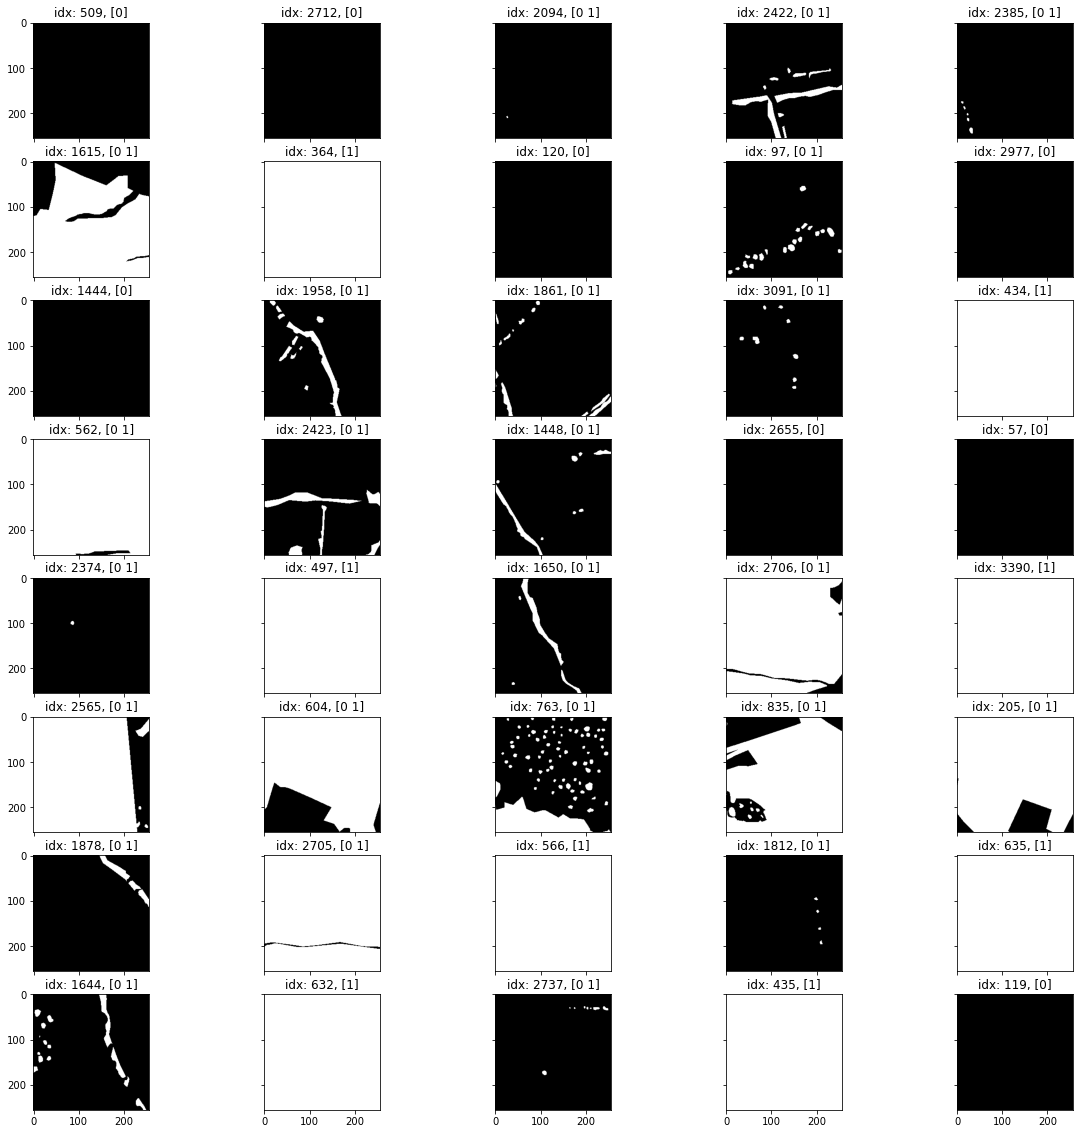

In [6]:
# Plot
n_col = 5
n_row = int(len(y_test)/n_col)

_, axs = plt.subplots(n_row, n_col, figsize=(20,20), sharex=True, sharey=True)
axs = axs.flatten()
cmap = cm.get_cmap('gray')
random.Random(4).shuffle(y_test)
random.Random(4).shuffle(X_test)

for c, (i, ax) in enumerate(zip(y_test, axs)):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap=cmap, vmin=0)
    ax.set_title(f'idx: {utis.get_file_index(i)}, {np.unique(img)}')
plt.show()

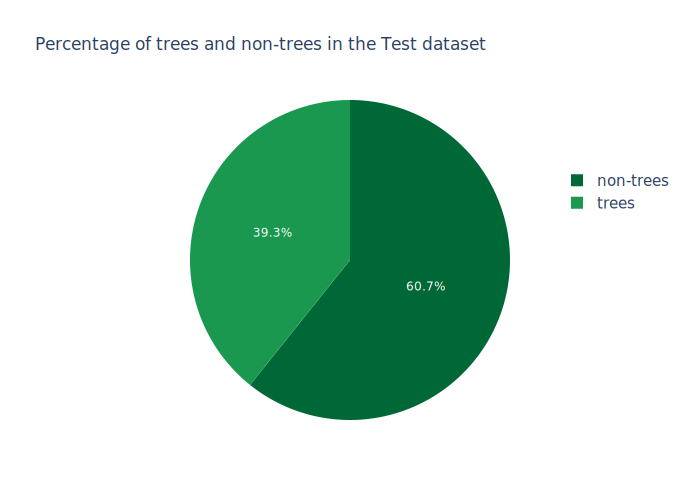

In [7]:
utis.plot_pizza(y_test, title='Test dataset')

### Check if CUDA is available

In [11]:
config.DEVICE

'cuda'

### Training and Validating

In [12]:
def train(model, dataloader, optim, lossFunc, epoch, scaler):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    dice = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward with autocast        
        with autocast():
            pred = model(x)
            loss = lossFunc(pred, y)
            
        optim.zero_grad()  # zero out any previously accumulated gradients    
        scaler.scale(loss).backward() # study this 
        scaler.step(optim)
        scaler.update()
        
#         # perform a forward pass and calculate the training loss
#         pred = model(x)
#         loss = lossFunc(pred, y)
        
#         opt.zero_grad()  # zero out any previously accumulated gradients
#         loss.backward() # obtain the gradients with respect to the loss
#         opt.step() # perform one step of gradient descendent
        
        totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        dice += all_metrics['dice_coeff']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'], dice = all_metrics['dice_coeff'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    avgDice = dice / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    training_history["IoU"].append(avgIOU) # save the acc 
    
    # WANDB
    # wandb.log({
    # # "Examples": example_images,
    # "Train Loss": avgTrainLoss,
    # "Train Accuracy": avgAccLoss,
    # "IoU_train":avgIOU})
    
    return training_history

In [13]:
def validation(model, dataloader, lossFunc, epoch):
    
    # set the model in evaluation mode
    model.eval()
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    # switch off autograd
    example_pred = []
    example_gt = []
    
    with torch.no_grad():
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        
        for batch_idx, (x_val, y_val) in enumerate(loop):
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']

            # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            # example_pred.append(wandb.Image(pred_val[0], caption=f"pred_iter_n_{batch_idx}"))
            # example_gt.append(wandb.Image(y_val[0].float(), caption=f"gt_iter_n_{batch_idx}"))
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])
                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the acc
    
    # WANDB
    # wandb.log({
    # "Predictions": example_pred,
    # "GT": example_gt,
    # "Val Accuracy": avgAccLoss,
    # "Val Loss": avgValLoss,
    # "IoU_val": avgIOU})
    
    return validation_history

### MAIN

In [14]:
# WandB – Initialize a new run
# wandb.init(entity="vibferreira", project="master_thesis")

# classes
classes = ('no_vegetation', 'vegetation')

# Initialize model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

opt = optim.Adam(unet.parameters(), lr=config.LR)
# opt = optim.SGD(unet.parameters(), lr=config.LR, momentum=0.95, weight_decay=0.01)
scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=10, verbose=True)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
# wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
iter_ = 0
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    # scheduler.step(validated['IoU_val'][-1])
    
    # Save best model
    if validated['IoU_val'][-1] > best_accuracy and e > 10: # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e, data_portion, rate_of_coarse_labels=n_patches)
        best_accuracy = validation_history['IoU_val'][-1]

Training the network for 100 epochs, with a batch size of 16


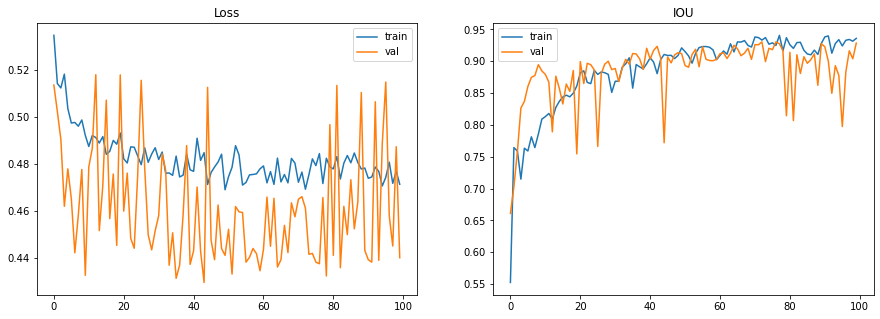

In [15]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(training_history['IoU'], label= 'train')
ax[1].plot(validation_history['IoU_val'], label='val')
ax[1].set_title('IOU')
ax[1].legend()
plt.show()

### Predictions

../best_model/coarse_sizes/rate_285_coarse_labels_best_model_epoch_77_iou_0.93_acc_0.972.pth


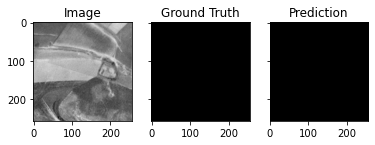

<Figure size 432x288 with 0 Axes>

Saving patch_0_id_509.tif


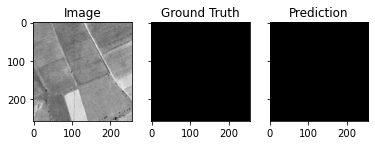

<Figure size 432x288 with 0 Axes>

Saving patch_1_id_2712.tif


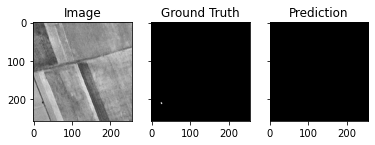

<Figure size 432x288 with 0 Axes>

Saving patch_2_id_2094.tif


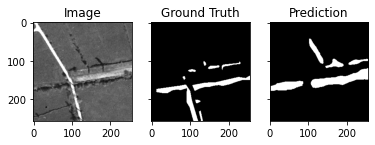

<Figure size 432x288 with 0 Axes>

Saving patch_3_id_2422.tif


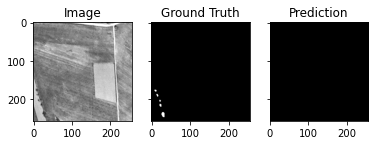

<Figure size 432x288 with 0 Axes>

Saving patch_4_id_2385.tif


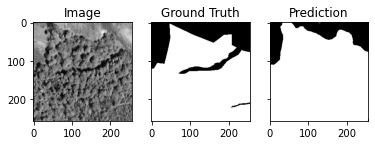

<Figure size 432x288 with 0 Axes>

Saving patch_5_id_1615.tif


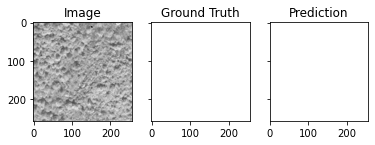

<Figure size 432x288 with 0 Axes>

Saving patch_6_id_364.tif


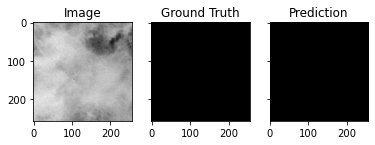

<Figure size 432x288 with 0 Axes>

Saving patch_7_id_120.tif


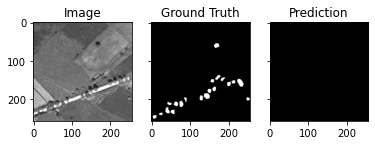

<Figure size 432x288 with 0 Axes>

Saving patch_8_id_97.tif


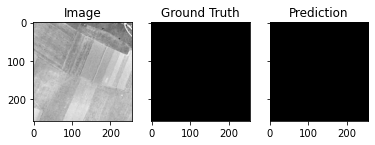

<Figure size 432x288 with 0 Axes>

Saving patch_9_id_2977.tif


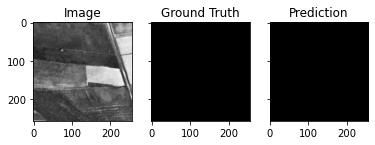

<Figure size 432x288 with 0 Axes>

Saving patch_10_id_1444.tif


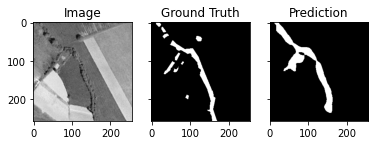

<Figure size 432x288 with 0 Axes>

Saving patch_11_id_1958.tif


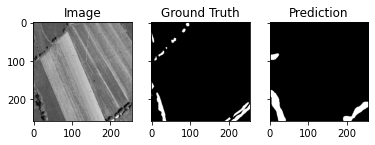

<Figure size 432x288 with 0 Axes>

Saving patch_12_id_1861.tif


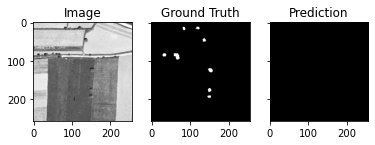

<Figure size 432x288 with 0 Axes>

Saving patch_13_id_3091.tif


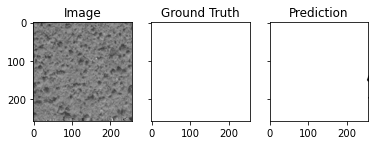

<Figure size 432x288 with 0 Axes>

Saving patch_14_id_434.tif


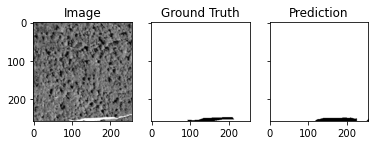

<Figure size 432x288 with 0 Axes>

Saving patch_15_id_562.tif


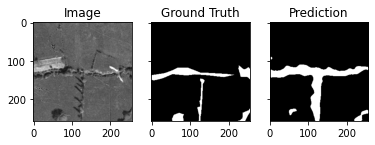

<Figure size 432x288 with 0 Axes>

Saving patch_16_id_2423.tif


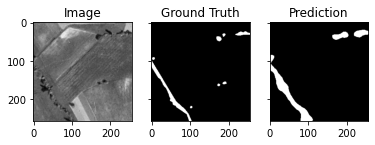

<Figure size 432x288 with 0 Axes>

Saving patch_17_id_1448.tif


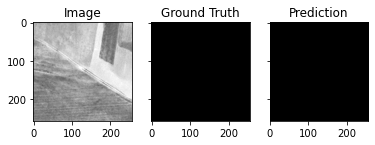

<Figure size 432x288 with 0 Axes>

Saving patch_18_id_2655.tif


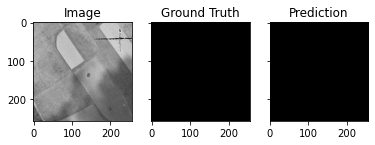

<Figure size 432x288 with 0 Axes>

Saving patch_19_id_57.tif


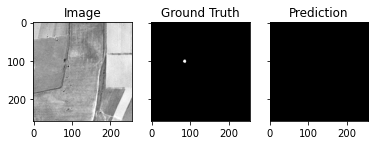

<Figure size 432x288 with 0 Axes>

Saving patch_20_id_2374.tif


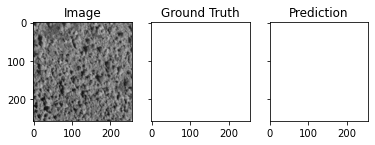

<Figure size 432x288 with 0 Axes>

Saving patch_21_id_497.tif


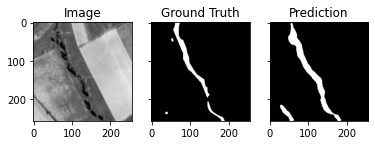

<Figure size 432x288 with 0 Axes>

Saving patch_22_id_1650.tif


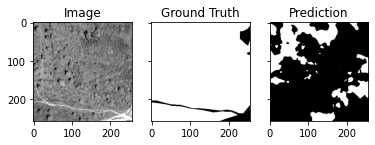

<Figure size 432x288 with 0 Axes>

Saving patch_23_id_2706.tif


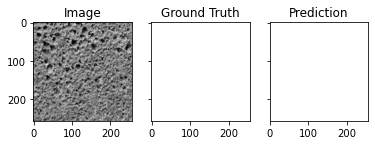

<Figure size 432x288 with 0 Axes>

Saving patch_24_id_3390.tif


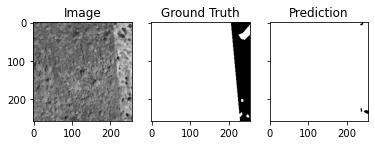

<Figure size 432x288 with 0 Axes>

Saving patch_25_id_2565.tif


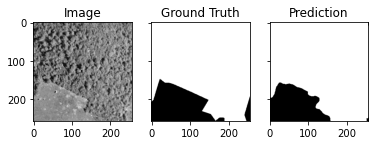

<Figure size 432x288 with 0 Axes>

Saving patch_26_id_604.tif


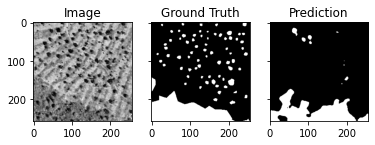

<Figure size 432x288 with 0 Axes>

Saving patch_27_id_763.tif


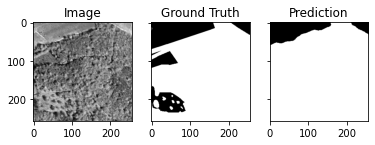

<Figure size 432x288 with 0 Axes>

Saving patch_28_id_835.tif


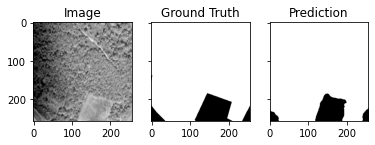

<Figure size 432x288 with 0 Axes>

Saving patch_29_id_205.tif


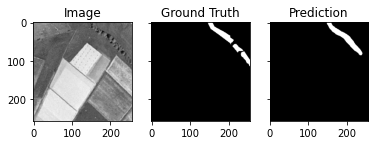

<Figure size 432x288 with 0 Axes>

Saving patch_30_id_1878.tif


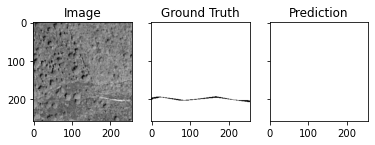

<Figure size 432x288 with 0 Axes>

Saving patch_31_id_2705.tif


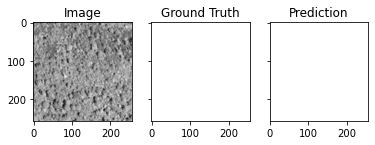

<Figure size 432x288 with 0 Axes>

Saving patch_32_id_566.tif


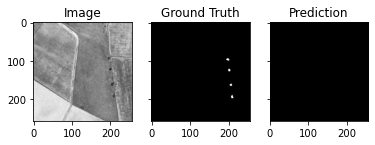

<Figure size 432x288 with 0 Axes>

Saving patch_33_id_1812.tif


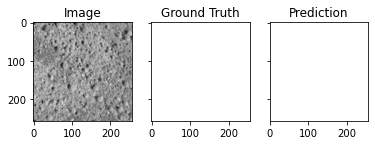

<Figure size 432x288 with 0 Axes>

Saving patch_34_id_635.tif


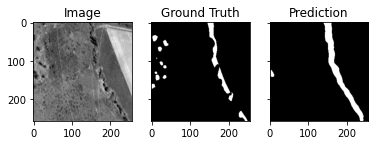

<Figure size 432x288 with 0 Axes>

Saving patch_35_id_1644.tif


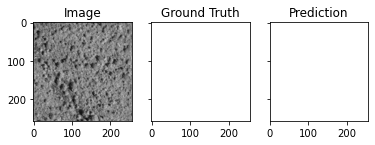

<Figure size 432x288 with 0 Axes>

Saving patch_36_id_632.tif


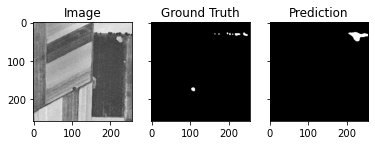

<Figure size 432x288 with 0 Axes>

Saving patch_37_id_2737.tif


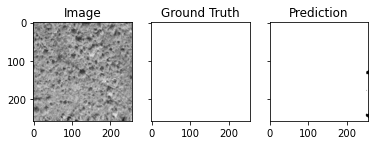

<Figure size 432x288 with 0 Axes>

Saving patch_38_id_435.tif


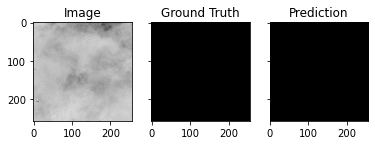

<Figure size 432x288 with 0 Axes>

Saving patch_39_id_119.tif


In [16]:
# set the model in evaluation model
BEST_MODEL = '../best_model/coarse_sizes/'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')[0]
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][0]
print(best_iou_model)
folder = '../saved_images'

model_ = model.unet_model.to(config.DEVICE)
model_.load_state_dict(torch.load(best_iou_model))

y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=True, save_patches=True)

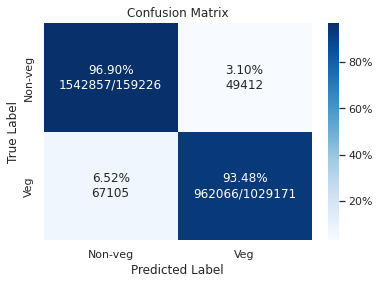

              precision    recall  f1-score   support

     Non-veg       0.96      0.97      0.96   1592269
         Veg       0.95      0.93      0.94   1029171

    accuracy                           0.96   2621440
   macro avg       0.95      0.95      0.95   2621440
weighted avg       0.96      0.96      0.96   2621440

IoU 0.8919721
F1 score 0.94290197
Dice score 0.94290197


In [17]:
labels = [0,1]
target_names = ['Non-veg', 'Veg']
metrics.cm_analysis(y_true, y_hat, labels, target_names)

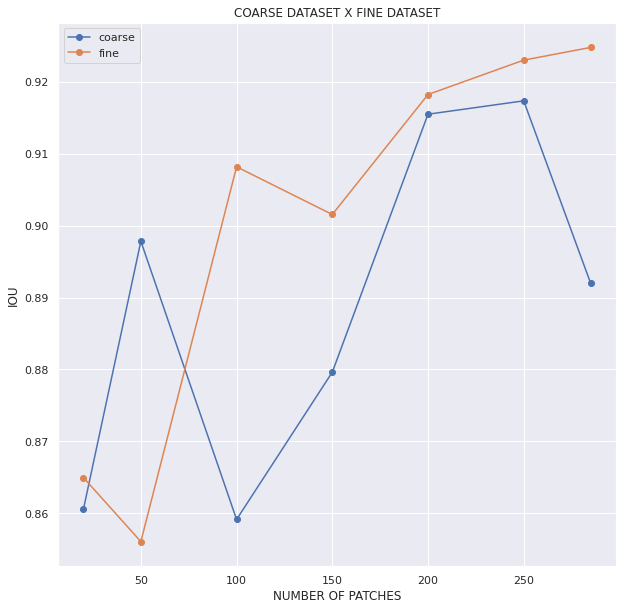

In [18]:
rates = [20, 50, 100, 150, 200, 250, 285]

# COARSE MODELS
folder = '../saved_images'
BEST_MODEL_COARSE = '../best_model/coarse_sizes'
best_iou_model_coarse = glob.glob(BEST_MODEL_COARSE + '/*.pth')
best_iou_model_coarse = sorted(best_iou_model_coarse, key= lambda x: int(re.split(r"[/_.]\s*", x)[8])) # sort files based on the number of patches

# FINE MODELS
BEST_MODEL_FINE = '../best_model/fine_sizes'
best_iou_model_fine = glob.glob(BEST_MODEL_FINE + '/*.pth')
best_iou_model_fine = sorted(best_iou_model_fine, key= lambda x: int(re.split(r"[/_.]\s*", x)[8])) # sort files based on the number of patches
  
iou_coarse = utis.iou_on_test_dataset(best_iou_model_coarse, rates, test_dataloader, X_test, folder)
iou_fine = utis.iou_on_test_dataset(best_iou_model_fine, rates, test_dataloader, X_test, folder)

plt.figure(figsize=(10,10))
plt.plot(iou_coarse.keys(),  iou_coarse.values(), label='coarse', marker='o')
plt.plot(iou_fine.keys(),  iou_fine.values(), label = 'fine', marker='o')
plt.legend()
plt.xlabel('NUMBER OF PATCHES')
plt.ylabel('IOU')
plt.title(f'COARSE DATASET X FINE DATASET')
plt.show()

In [19]:
# # WandB – Initialize a new run
# # wandb.init(entity="vibferreira", project="master_thesis")

# # set the model in evaluation model
# data_portion= 'coarse_labels'
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][0]
# print(best_iou_model)
# folder = '../saved_images'

# # load the model 
# model_ = model.unet_model.to(config.DEVICE)
# model_.load_state_dict(torch.load(best_iou_model))

# y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder)

In [20]:
# # set the model in evaluation model
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model.sort()
# portions = ['coarse_plus_fine_labels', 'coarse_labels', 'fine_labels']
# portions.sort()
# folder = '../saved_images'

# for i, p in zip(best_iou_model, portions):
#     # load the model 
#     model_ = model.unet_model.to(config.DEVICE)
#     model_.load_state_dict(torch.load(i))
    
#     y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=False)
#     y_hat, y_true, y_score = y_hat.detach().cpu().numpy(), y_true.detach().cpu().numpy(), y_score.detach().cpu().numpy()
    
#     fpr, tpr, thresholds = roc_curve(y_true, y_score)
#     roc_auc = auc(fpr, tpr)

#     lw = 2
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.15)
#     plt.plot(fpr, tpr, lw=lw, label=f'{p} (area = {roc_auc: 0.4f})')

#     plt.xlabel('Specificity - False Positive Rate')
#     plt.ylabel('Sensitivity - True Positive Rate')
#     plt.title(f'ROC')
#     plt.legend(loc="lower right")